In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from causallearn.search.ScoreBased.GES import ges
from tqdm import tqdm
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### DATA LOADING & PREPROCESSING

In [2]:
df = pd.read_csv("final_df_all_years.csv")

variables = [
    "smoking_status", "RIDAGEYR", "RIAGENDR", "RIDRETH1", "INDHHIN2", "BMXBMI",
    "MCQ160O","MCQ160K","MCQ160E","MCQ160C","MCQ160B","MCQ160F",
    "MCQ220","MCQ160M","MCQ010"
]

df = df[variables].dropna().reset_index(drop=True)

categorical_cols = [
    "smoking_status","RIAGENDR","RIDRETH1","INDHHIN2",
    "MCQ160O","MCQ160K","MCQ160E","MCQ160C","MCQ160B",
    "MCQ160F","MCQ220","MCQ160M","MCQ010"
]

def encode_df(df, categorical_cols):
    mapping = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        mapping[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    return mapping

encoding_maps = encode_df(df, categorical_cols)

data_np = df.values
colnames = df.columns.tolist()
p = len(colnames)

# GES PRELIMINARY ANALYSIS

### GES ADJACENCY MATRIX EXTRACTION

In [3]:
def extract_adj_matrix_from_ges_result(result, p):
    """
    -1 : i → j
     1 : j → i
     2 : undirected i — j
     0 : no edge
    """
    G = result['G']
    amat = np.zeros((p, p), dtype=int)

    for i in range(p):
        for j in range(p):
            val = G.graph[i, j]
            if val == -1:  # i → j
                amat[i, j] = 1
            elif val == 1:  # j → i
                amat[j, i] = 1
            elif val == 2:
                amat[i, j] = 1
                amat[j, i] = 1

    return amat

### BASELINE GES ESTIMATION

In [4]:
score_method = "local_score_BIC"
n_bootstraps = 30

print("\nRunning baseline GES...")
ges_baseline = ges(data_np, score_func=score_method)
amat_baseline = extract_adj_matrix_from_ges_result(ges_baseline, p)


Running baseline GES...


### STRUCTURAL HAMMING DISTANCE (SHD)

In [5]:
def compute_shd(a1, a2):
    p = a1.shape[0]
    shd = 0
    for i in range(p):
        for j in range(i+1, p):
            if (a1[i,j] != a2[i,j]) or (a1[j,i] != a2[j,i]):
                shd += 1
    return shd

### BOOTSTRAP STRUCTURE LEARNING

In [6]:
edge_count = {(i,j): 0 for i in range(p) for j in range(i+1,p)}
orient_count = {(i,j): [0,0,0] for i in range(p) for j in range(i+1,p)} 
shd_list = []
rng = np.random.default_rng(42)

print("\nPerforming bootstrap resampling...")
for b in tqdm(range(n_bootstraps)):
    idx = rng.integers(0, len(df), len(df))
    sample = df.iloc[idx].values

    try:
        res = ges(sample, score_func=score_method)
    except Exception as e:
        print("GES failed at bootstrap", b, ":", e)
        continue
    
    amat = extract_adj_matrix_from_ges_result(res, p)

    for i in range(p):
        for j in range(i+1,p):
            a_ij, a_ji = amat[i,j], amat[j,i]

            # Edge presence
            if a_ij or a_ji:
                edge_count[(i,j)] += 1

            # Edge orientation
            if a_ij and not a_ji:
                orient_count[(i,j)][0] += 1
            elif a_ji and not a_ij:
                orient_count[(i,j)][1] += 1
            elif a_ij and a_ji:
                orient_count[(i,j)][2] += 1

    shd_list.append(compute_shd(amat_baseline, amat))

print(f"\nBootstrap complete: {n_bootstraps} resamples.")


Performing bootstrap resampling...


100%|███████████████████████████████████████████| 30/30 [16:39<00:00, 33.32s/it]


Bootstrap complete: 30 resamples.


### STABILITY SUMMARY DATAFRAME

In [7]:
rows = []
for (i, j), ec in edge_count.items():
    i2j, j2i, und = orient_count[(i, j)]

    rows.append({
        "var_i": colnames[i],
        "var_j": colnames[j],
        "edge_freq": ec / n_bootstraps,
        "i->j_freq": i2j / n_bootstraps,
        "j->i_freq": j2i / n_bootstraps,
        "undirected_freq": und / n_bootstraps,
        "direction_certainty": max(i2j, j2i) / n_bootstraps
    })

# Full stability table
stab_df = pd.DataFrame(rows).sort_values("edge_freq", ascending=False)
smoking_edges = stab_df[
    (stab_df["var_i"] == "smoking_status") |
    (stab_df["var_j"] == "smoking_status")
]

print("\n=== ALL Edges Involving Smoking_Status ===")
smoking_edges


=== ALL Edges Involving Smoking_Status ===


var_i     var_j  edge_freq  i->j_freq  j->i_freq  \
3   smoking_status  INDHHIN2   1.000000   0.800000   0.200000   
6   smoking_status   MCQ160K   1.000000   0.000000   1.000000   
10  smoking_status   MCQ160F   1.000000   0.066667   0.933333   
1   smoking_status  RIAGENDR   1.000000   0.000000   1.000000   
13  smoking_status    MCQ010   0.966667   0.066667   0.900000   
5   smoking_status   MCQ160O   0.900000   0.566667   0.333333   
7   smoking_status   MCQ160E   0.900000   0.000000   0.900000   
4   smoking_status    BMXBMI   0.833333   0.233333   0.600000   
0   smoking_status  RIDAGEYR   0.000000   0.000000   0.000000   
2   smoking_status  RIDRETH1   0.000000   0.000000   0.000000   
8   smoking_status   MCQ160C   0.000000   0.000000   0.000000   
9   smoking_status   MCQ160B   0.000000   0.000000   0.000000   
11  smoking_status    MCQ220   0.000000   0.000000   0.000000   
12  smoking_status   MCQ160M   0.000000   0.000000   0.000000   

    undirected_freq  direction_certainty  
3               0.0             0.800000  
6               0.0             1.000000  
10              0.0             0.933333  
1               0.0             1.000000  
13              0.0             0.900000  
5               0.0             0.566667  
7               0.0             0.900000  
4               0.0             0.600000  
0               0.0             0.000000  
2               0.0             0.000000  
8               0.0             0.000000  
9               0.0             0.000000  
11              0.0             0.000000  
12              0.0             0.000000

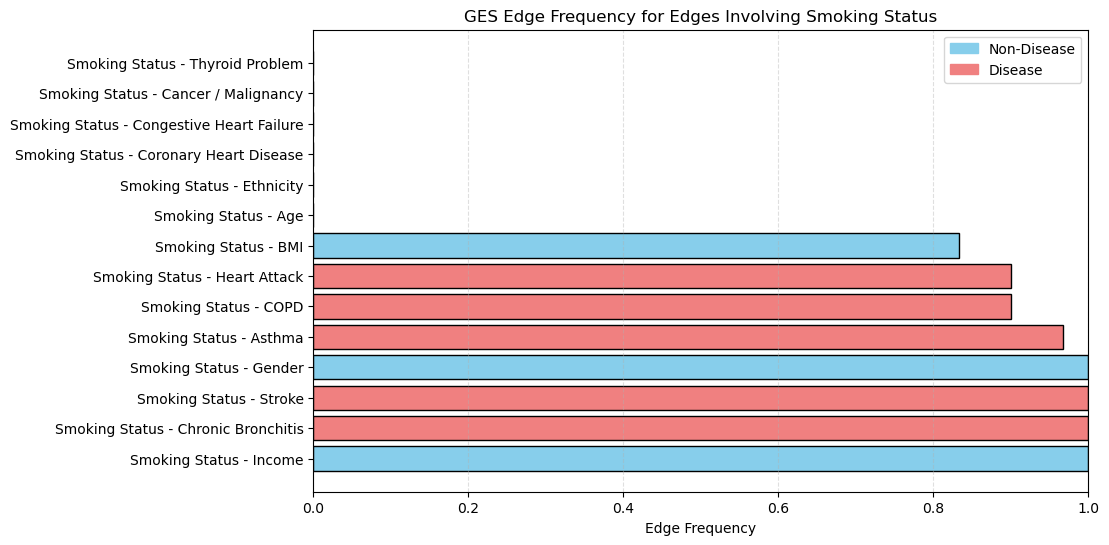

In [8]:
friendly_labels = {
    "smoking_status": "Smoking Status",
    "BMXBMI": "BMI",
    "MCQ160O": "COPD",
    "MCQ160K": "Chronic Bronchitis",
    "MCQ160E": "Heart Attack",
    "MCQ160C": "Coronary Heart Disease",
    "MCQ160B": "Congestive Heart Failure",
    "MCQ160F": "Stroke",
    "MCQ220": "Cancer / Malignancy",
    "MCQ160M": "Thyroid Problem",
    "MCQ010": "Asthma",
    "RIDAGEYR": "Age",
    "RIAGENDR": "Gender",
    "RIDRETH1": "Ethnicity",
    "INDHHIN2": "Income"
}

demographic_vars = ["RIDAGEYR", "RIAGENDR", "RIDRETH1", "INDHHIN2"]
disease_vars = [
    "MCQ160O","MCQ160K","MCQ160E","MCQ160C","MCQ160B",
    "MCQ160F","MCQ220","MCQ160M","MCQ010"
]
bmi_var = "BMXBMI"

edge_labels = []
edge_values = []
edge_colors = []

for _, row in smoking_edges.iterrows():
    var_i = row["var_i"]
    var_j = row["var_j"]
    freq = row["edge_freq"]

    other = var_j if var_i == "smoking_status" else var_i
    if var_i == "smoking_status":
        label = f"{friendly_labels['smoking_status']} - {friendly_labels.get(var_j, var_j)}"
    else:
        label = f"{friendly_labels.get(var_i, var_i)} - {friendly_labels['smoking_status']}"

    edge_labels.append(label)
    edge_values.append(freq)

    if other in demographic_vars or other == bmi_var:
        edge_colors.append("skyblue")        # demographic
    elif other in disease_vars:
        edge_colors.append("lightcoral")
    else:
        edge_colors.append("gray")           # fallback

plt.figure(figsize=(10, 6))
plt.barh(edge_labels, edge_values, color=edge_colors, edgecolor="black")
plt.xlabel("Edge Frequency")
plt.title("GES Edge Frequency for Edges Involving Smoking Status")
plt.xlim(0, 1)
plt.grid(axis="x", linestyle="--", alpha=0.4)

import matplotlib.patches as mpatches
plt.legend(
    handles=[
        mpatches.Patch(color="skyblue", label="Non-Disease"),
        mpatches.Patch(color="lightcoral", label="Disease"),
    ],
    loc="upper right"
)

plt.show()

### UNDIRECTED AND DIRECTED EDGES

In [9]:
def classify_edges(stab_subset, dir_threshold=0.6,
                   undirected_low=0.4, undirected_high=0.6):
    directed_edges = []
    undirected_edges = []

    for _, row in stab_subset.iterrows():
        if row["edge_freq"] == 0:
            continue

        var_i = row["var_i"]
        var_j = row["var_j"]

        i2j_freq = row["i->j_freq"]
        j2i_freq = row["j->i_freq"]
        direction_certainty = row["direction_certainty"]

        if direction_certainty >= dir_threshold:
            if i2j_freq >= j2i_freq:
                directed_edges.append((var_i, var_j))
            else:
                directed_edges.append((var_j, var_i))

        elif undirected_low <= direction_certainty < undirected_high:
            undirected_edges.append((var_i, var_j))
        else:
            undirected_edges.append((var_i, var_j))

    return directed_edges, undirected_edges

smoking_directed, smoking_undirected = classify_edges(smoking_edges)

print("\n=== Smoking_Status Edges Only ===")

print("\nDirected Edges (with arrow):")
for u, v in smoking_directed:
    print(f"{u} → {v}")
print("Total directed:", len(smoking_directed))

print("\nUndirected Edges (no arrow):")
for u, v in smoking_undirected:
    print(f"{u} — {v}")
print("Total undirected:", len(smoking_undirected))


=== Smoking_Status Edges Only ===

Directed Edges (with arrow):
smoking_status → INDHHIN2
MCQ160K → smoking_status
MCQ160F → smoking_status
RIAGENDR → smoking_status
MCQ010 → smoking_status
MCQ160E → smoking_status
BMXBMI → smoking_status
Total directed: 7

Undirected Edges (no arrow):
smoking_status — MCQ160O
Total undirected: 1


# GES SUBGROUP STABILITY ANALYSIS

In [10]:
baseline_edge_freq_raw = {}

for _, row in smoking_edges.iterrows():
    var_i = row["var_i"]
    var_j = row["var_j"]
    edge_freq = row["edge_freq"]
    other = var_j if var_i == "smoking_status" else var_i
    key = f"smoking_status--{other}"
    baseline_edge_freq_raw[key] = edge_freq

In [11]:
light_blue  = "#87CEFA"   
dark_blue   = "#1E90FF"   

light_red   = "#F08080"   
dark_red    = "#B22222"  

light_gray  = "#D3D3D3"
dark_gray   = "#808080"


In [12]:
def pair_key(i, j):
    return tuple(sorted((i, j)))

def run_ges_subgroup_analysis_smoking_only(
    df, demographic_col, label_map, n_bootstraps=30
):
    print(f"\n===== Running GES Smoking-Only Subgroup Analysis for {demographic_col} =====")

    subgroup_label_map = {v: k for k, v in encoding_maps[demographic_col].items()}
    subgroup_values = df[demographic_col].unique()
    subgroup_results = {}
    local_targets = smoking_target_vars  
    p = len(colnames)

    for subgroup in subgroup_values:
        subgroup_name = subgroup_label_map[subgroup]
        print(f"\nSubgroup: {subgroup_name} ({demographic_col})")

        df_sub = df[df[demographic_col] == subgroup].reset_index(drop=True)
        n_sub = len(df_sub)

        edge_count = {pair_key(i, j): 0 for i in range(p) for j in range(i+1, p)}
        orient_count = {pair_key(i, j): [0, 0, 0] for i in range(p) for j in range(i+1, p)}

        rng = np.random.default_rng(seed=42)

        for b in tqdm(range(n_bootstraps), desc=f"Bootstraps ({subgroup_name})"):
            idx = rng.integers(0, n_sub, n_sub)
            sample = df_sub.iloc[idx].values.astype(float)
            sample += np.random.normal(0, 1e-8, size=sample.shape)

            try:
                res = ges(sample, score_func=score_method)
            except:
                continue

            amat = extract_adj_matrix_from_ges_result(res, p)

            for i in range(p):
                for j in range(i+1, p):
                    a_ij, a_ji = amat[i, j], amat[j, i]

                    if a_ij or a_ji:
                        edge_count[(i, j)] += 1

                    if a_ij and not a_ji:
                        orient_count[(i, j)][0] += 1
                    elif a_ji and not a_ij:
                        orient_count[(i, j)][1] += 1
                    elif a_ij and a_ji:
                        orient_count[(i, j)][2] += 1

        rows = []
        for (i, j), ec in edge_count.items():
            var_i = colnames[i]
            var_j = colnames[j]
            if "smoking_status" not in (var_i, var_j):
                continue

            other_var = var_j if var_i == "smoking_status" else var_i

            if other_var not in local_targets:
                continue

            i_to_j, j_to_i, undir = orient_count[(i, j)]

            rows.append({
                "var_i": var_i,
                "var_j": var_j,
                "other_var": other_var,
                "edge_freq": ec / n_bootstraps,
                "i->j_freq": i_to_j / n_bootstraps,
                "j->i_freq": j_to_i / n_bootstraps,
                "undirected_freq": undir / n_bootstraps,
            })

        subgroup_results[subgroup_name] = pd.DataFrame(rows)

    all_edges = [f"smoking_status--{v}" for v in local_targets]

    freq_matrix = pd.DataFrame(
        index=all_edges,
        columns=[subgroup_label_map[s] for s in subgroup_values],
        dtype=float
    ).fillna(0)

    for subgroup in subgroup_values:
        subgroup_name = subgroup_label_map[subgroup]
        df_sub = subgroup_results[subgroup_name]

        for _, row in df_sub.iterrows():
            edge_name = f"{row['var_i']}--{row['var_j']}"
            freq_matrix.loc[edge_name, subgroup_name] = row["edge_freq"]

    freq_matrix = freq_matrix[sorted(freq_matrix.columns, key=lambda x: int(float(x)))]
    freq_matrix.columns = [
        label_map.get(int(float(c)), str(c)) 
        for c in freq_matrix.columns
    ]
    friendly_index = [
        f"{friendly_labels['smoking_status']} - {friendly_labels.get(v, v)}"
        for v in local_targets
    ]
    freq_matrix.index = friendly_index

    plt.figure(figsize=(12, 0.5*len(freq_matrix)))
    sns.heatmap(freq_matrix, cmap="Blues", annot=True, fmt=".2f", vmin=0, vmax=1)
    plt.title(f"Smoking - Outcome Edge Frequencies Across {demographic_col} Subgroups")
    plt.show()

    sd_within = freq_matrix.std(axis=1)

    sd_vs_baseline = []
    for raw_target in local_targets:
        baseline_key = f"smoking_status--{raw_target}"
        base_val = baseline_edge_freq_raw.get(baseline_key, 0)

        friendly_label = f"{friendly_labels['smoking_status']} - {friendly_labels.get(raw_target, raw_target)}"
        subgroup_vals = freq_matrix.loc[friendly_label].values.astype(float).tolist()

        sd_vs_baseline.append(np.std(subgroup_vals + [base_val]))

    variation_df = pd.DataFrame({
        "Edge": list(freq_matrix.index)*2,
        "SD": list(sd_within.values) + sd_vs_baseline,
        "Type": ["Within Subgroups"]*len(sd_within) + ["Baseline + Subgroups"]*len(sd_vs_baseline)
    })

    variation_df_sorted = (
    variation_df.sort_values("SD", ascending=True)
    )
    

    plt.figure(figsize=(12, 7))

    sns.barplot(
        data=variation_df_sorted,
        y="Edge",
        x="SD",
        hue="Type",
        orient="h"
    )

    plt.xlabel("Standard Deviation (Variation)")
    plt.ylabel("Edge")
    plt.xlim(0,1)
    plt.title(f"Variation of Smoking - Outcome Edges Across {demographic_col} Subgroups")
    plt.tight_layout()
    plt.show()

    return freq_matrix, subgroup_results



def extract_bootstrap_edges(stab_df, dir_thresh=0.7, undirected_thresh=0.8):
    directed_edges = []
    undirected_edges = []

    for _, row in stab_df.iterrows():
        var_i = row["var_i"]
        var_j = row["var_j"]

        edge_freq = row["edge_freq"]
        i_to_j = row["i->j_freq"]
        j_to_i = row["j->i_freq"]

        if edge_freq < undirected_thresh:
            continue

        if i_to_j >= dir_thresh and i_to_j > j_to_i:
            directed_edges.append((var_i, var_j))
        elif j_to_i >= dir_thresh and j_to_i > i_to_j:
            directed_edges.append((var_j, var_i))
        else:
            undirected_edges.append((var_i, var_j))

    return directed_edges, undirected_edges


In [13]:
def create_full_direction_matrix(subgroup_results, demographic_col, label_map, friendly_labels):
    all_raw_edges = set()
    for sub_df in subgroup_results.values():
        for _, row in sub_df.iterrows():
            var_i, var_j = row['var_i'], row['var_j']
            other_var = var_j if var_i == 'smoking_status' else var_i
            all_raw_edges.add(f"smoking_status--{other_var}")

    sorted_raw_edges = sorted(list(all_raw_edges), key=lambda x: x.split('--')[1])
    
    friendly_indices_map = {
        raw_edge: f"{friendly_labels['smoking_status']} — {friendly_labels.get(raw_edge.split('--')[1], raw_edge.split('--')[1])}"
        for raw_edge in sorted_raw_edges
    }
    friendly_indices = list(friendly_indices_map.values())
    
    subgroup_names = sorted(subgroup_results.keys())
    final_cols = []
    for name in subgroup_names:
        friendly_name = label_map.get(name, str(name))
        final_cols.extend([
            f"{friendly_name} (i->j)", 
            f"{friendly_name} (j->i)", 
            f"{friendly_name} (Undirected)",
            f"{friendly_name} (Directional Score)"
        ])
        
    direction_matrix = pd.DataFrame(index=friendly_indices, columns=final_cols, dtype=float).fillna(0.0)

    for subgroup_name, sub_df in subgroup_results.items():
        friendly_sub_name = label_map.get(subgroup_name, str(subgroup_name))
        
        for _, row in sub_df.iterrows():
            var_i, var_j = row['var_i'], row['var_j']
            other_var = var_j if var_i == 'smoking_status' else var_i
            
            raw_edge_key = f"smoking_status--{other_var}"
            row_index_name = friendly_indices_map.get(raw_edge_key)

            if var_i == 'smoking_status':
                i2j_freq = row['i->j_freq']
                j2i_freq = row['j->i_freq']
            else: 
                i2j_freq = row['j->i_freq']
                j2i_freq = row['i->j_freq']
            
            undir_freq = row['undirected_freq']

            directional_score = i2j_freq - j2i_freq

            direction_matrix.loc[row_index_name, f"{friendly_sub_name} (i->j)"] = i2j_freq
            direction_matrix.loc[row_index_name, f"{friendly_sub_name} (j->i)"] = j2i_freq
            direction_matrix.loc[row_index_name, f"{friendly_sub_name} (Undirected)"] = undir_freq
            direction_matrix.loc[row_index_name, f"{friendly_sub_name} (Directional Score)"] = directional_score

    
    instability_scores = {}
    
    for friendly_index in friendly_indices:
        scores = direction_matrix.loc[friendly_index].filter(like='(Directional Score)').values
        directional_instability = np.max(scores) - np.min(scores)
        
        instability_scores[friendly_index] = directional_instability

    instability_df = pd.DataFrame.from_dict(
        instability_scores, 
        orient='index', 
        columns=['Directional Instability (Range)']
    ).sort_values(
        'Directional Instability (Range)', 
        ascending=False
    )
    
    print(f"\n=== Edge Direction Stability for {demographic_col} Subgroups ===")
    print(instability_df)
    
    return direction_matrix, instability_df

### AGE-BASED SUBGROUP ANALYSIS


===== Running GES Smoking-Only Subgroup Analysis for age_group =====

Subgroup: 2 (age_group)


Bootstraps (2): 100%|███████████████████████████| 30/30 [04:30<00:00,  9.03s/it]



Subgroup: 5 (age_group)


Bootstraps (5): 100%|███████████████████████████| 30/30 [06:22<00:00, 12.75s/it]



Subgroup: 1 (age_group)


Bootstraps (1): 100%|███████████████████████████| 30/30 [03:14<00:00,  6.47s/it]



Subgroup: 3 (age_group)


Bootstraps (3): 100%|███████████████████████████| 30/30 [06:53<00:00, 13.78s/it]



Subgroup: 7 (age_group)


Bootstraps (7): 100%|███████████████████████████| 30/30 [02:26<00:00,  4.87s/it]



Subgroup: 4 (age_group)


Bootstraps (4): 100%|███████████████████████████| 30/30 [06:48<00:00, 13.63s/it]



Subgroup: 6 (age_group)


Bootstraps (6): 100%|███████████████████████████| 30/30 [03:51<00:00,  7.70s/it]


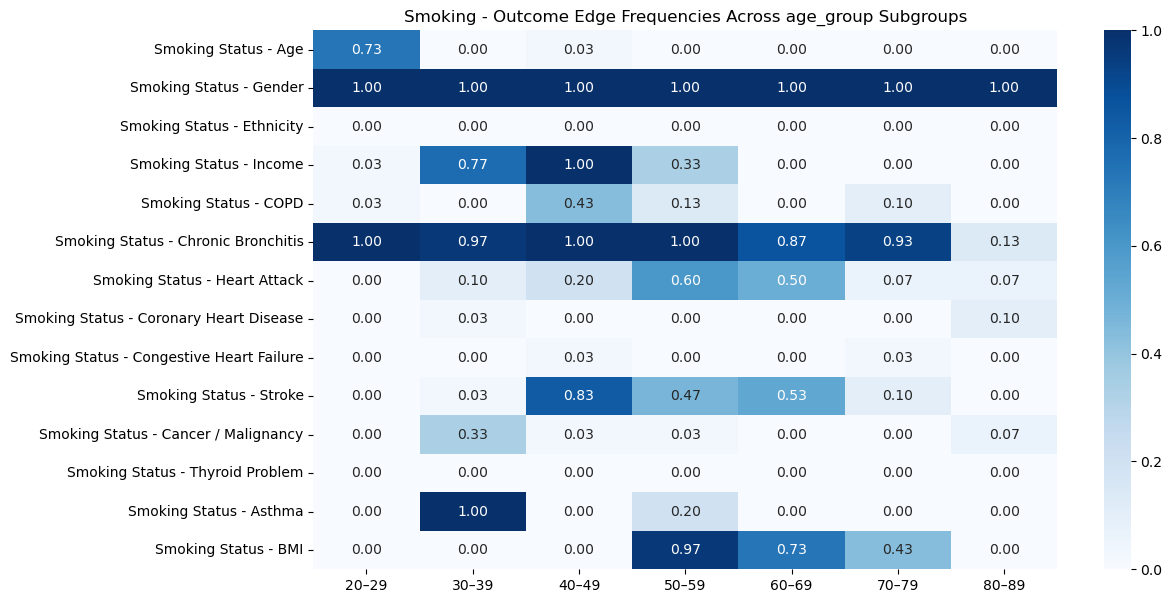

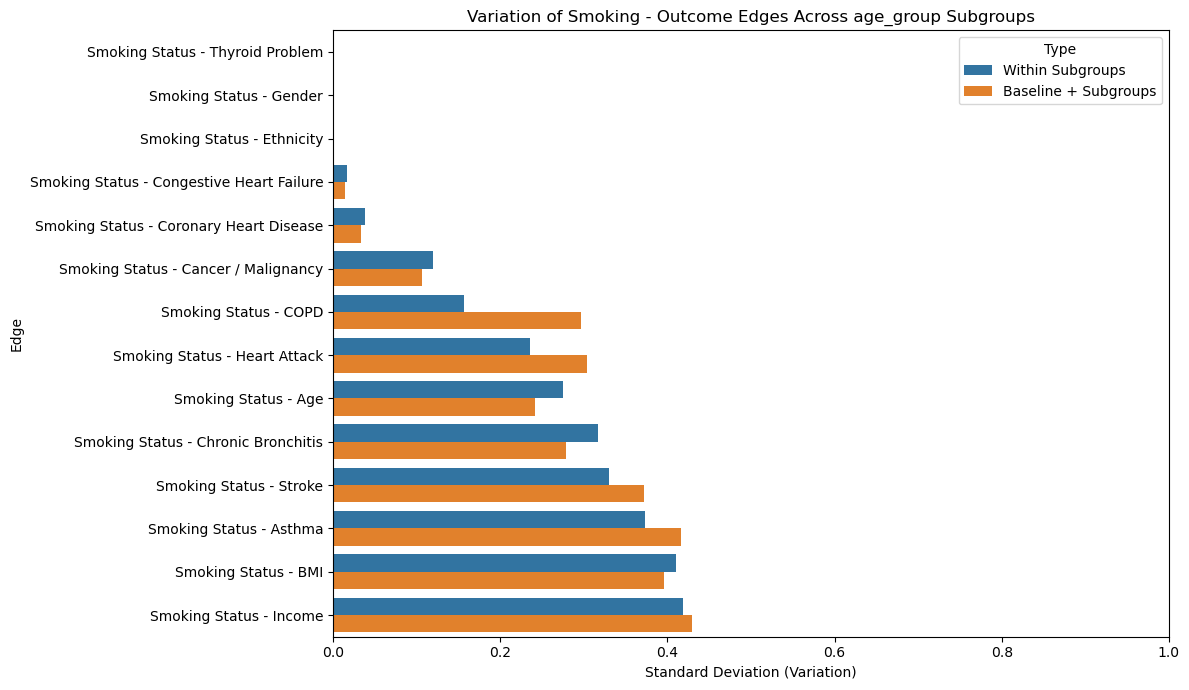


=== Edge Direction Stability for Age Group Subgroups ===
                                           Directional Instability (Range)
Smoking Status — Income                                           0.966667
Smoking Status — Gender                                           0.933333
Smoking Status — Chronic Bronchitis                               0.766667
Smoking Status — Asthma                                           0.700000
Smoking Status — Heart Attack                                     0.433333
Smoking Status — BMI                                              0.366667
Smoking Status — Age                                              0.333333
Smoking Status — Stroke                                           0.166667
Smoking Status — COPD                                             0.100000
Smoking Status — Congestive Heart Failure                         0.066667
Smoking Status — Cancer / Malignancy                              0.066667
Smoking Status — Coronary Heart Disease   

In [14]:
smoking_target_vars = ["RIDAGEYR", "RIAGENDR", "RIDRETH1", "INDHHIN2","MCQ160O","MCQ160K","MCQ160E","MCQ160C","MCQ160B","MCQ160F","MCQ220","MCQ160M","MCQ010", "BMXBMI"]

age_bins = [10, 19, 29, 39, 49, 59, 69, 79, 89, 120]
age_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8]

df["age_group"] = pd.cut(
    df["RIDAGEYR"], 
    bins=age_bins, 
    labels=age_labels, 
    right=True
)

df["age_group"] = df["age_group"].astype(int)
encoding_maps["age_group"] = {i: i for i in df["age_group"].unique()}

age_label_map = {
    1: "20–29",
    2: "30–39",
    3: "40–49",
    4: "50–59",
    5: "60–69",
    6: "70–79",
    7: "80–89",
}


age_freq_matrix, age_subgroups = run_ges_subgroup_analysis_smoking_only(
    df=df,
    demographic_col="age_group",
    label_map=age_label_map,
    n_bootstraps=30
)

age_direction_matrix, age_instability_df = create_full_direction_matrix(
    subgroup_results=age_subgroups,
    demographic_col="Age Group",
    label_map=age_label_map,
    friendly_labels=friendly_labels
)


age_freq_matrix.to_excel("age_freq_matrix.xlsx")
age_direction_matrix.to_excel("age_direction_matrix.xlsx")
age_instability_df.to_excel("age_instability_df.xlsx")
with pd.ExcelWriter("age_subgroups_raw_data.xlsx") as writer:
    for subgroup_name, df_data in age_subgroups.items():
        df_data.to_excel(writer, sheet_name=str(subgroup_name))

### ETHNICITY-BASED SUBGROUP ANALYSIS


===== Running GES Smoking-Only Subgroup Analysis for RIDRETH1 =====

Subgroup: 3.0 (RIDRETH1)


Bootstraps (3.0): 100%|█████████████████████████| 30/30 [09:32<00:00, 19.08s/it]



Subgroup: 4.0 (RIDRETH1)


Bootstraps (4.0): 100%|█████████████████████████| 30/30 [07:56<00:00, 15.89s/it]



Subgroup: 1.0 (RIDRETH1)


Bootstraps (1.0): 100%|█████████████████████████| 30/30 [06:01<00:00, 12.04s/it]



Subgroup: 2.0 (RIDRETH1)


Bootstraps (2.0): 100%|█████████████████████████| 30/30 [05:19<00:00, 10.65s/it]



Subgroup: 5.0 (RIDRETH1)


Bootstraps (5.0): 100%|█████████████████████████| 30/30 [07:15<00:00, 14.52s/it]


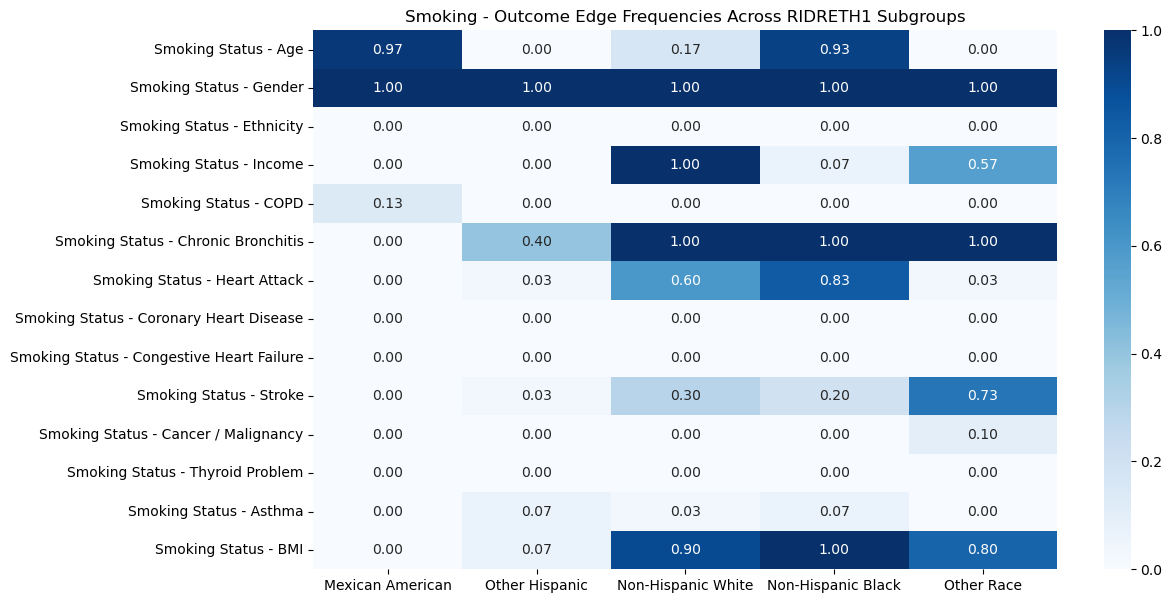

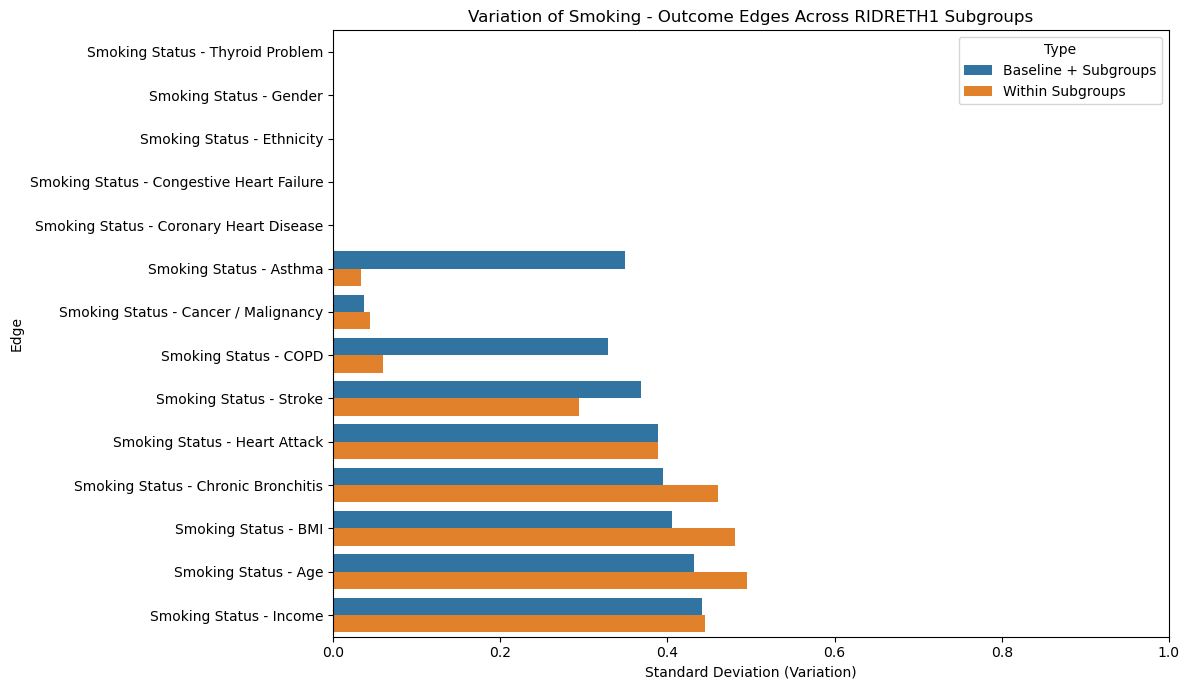


=== Edge Direction Stability for Ethnicity Subgroups ===
                                           Directional Instability (Range)
Smoking Status — Gender                                           1.766667
Smoking Status — Chronic Bronchitis                               1.000000
Smoking Status — Stroke                                           0.766667
Smoking Status — BMI                                              0.733333
Smoking Status — Age                                              0.366667
Smoking Status — Income                                           0.333333
Smoking Status — Heart Attack                                     0.133333
Smoking Status — Asthma                                           0.066667
Smoking Status — Cancer / Malignancy                              0.033333
Smoking Status — Congestive Heart Failure                         0.000000
Smoking Status — Coronary Heart Disease                           0.000000
Smoking Status — Thyroid Problem          

In [15]:
ethnicity_label_map = { 
    1: "Mexican American", 
    2: "Other Hispanic", 
    3: "Non-Hispanic White", 
    4: "Non-Hispanic Black", 
    5: "Other Race", 
} 

eth_freq_matrix, ethnicity_subgroups = run_ges_subgroup_analysis_smoking_only(
    df=df, 
    demographic_col="RIDRETH1", 
    label_map=ethnicity_label_map, 
    n_bootstraps=30
)

eth_direction_matrix, eth_instability_df = create_full_direction_matrix(
    subgroup_results=ethnicity_subgroups,
    demographic_col="Ethnicity",
    label_map=ethnicity_label_map,
    friendly_labels=friendly_labels
)

eth_freq_matrix.to_excel("eth_freq_matrix.xlsx")
eth_direction_matrix.to_excel("eth_direction_matrix.xlsx")
eth_instability_df.to_excel("eth_instability_df.xlsx")
with pd.ExcelWriter("ethnicity_subgroups_raw_data.xlsx") as writer:
    for subgroup_name, df_data in ethnicity_subgroups.items():
        df_data.to_excel(writer, sheet_name=str(subgroup_name))

### GENDER-BASED SUBGROUP ANALYSIS


===== Running GES Smoking-Only Subgroup Analysis for RIAGENDR =====

Subgroup: 1.0 (RIAGENDR)


Bootstraps (1.0): 100%|████████████████████████| 30/30 [54:56<00:00, 109.89s/it]



Subgroup: 2.0 (RIAGENDR)


Bootstraps (2.0): 100%|█████████████████████████| 30/30 [11:52<00:00, 23.77s/it]


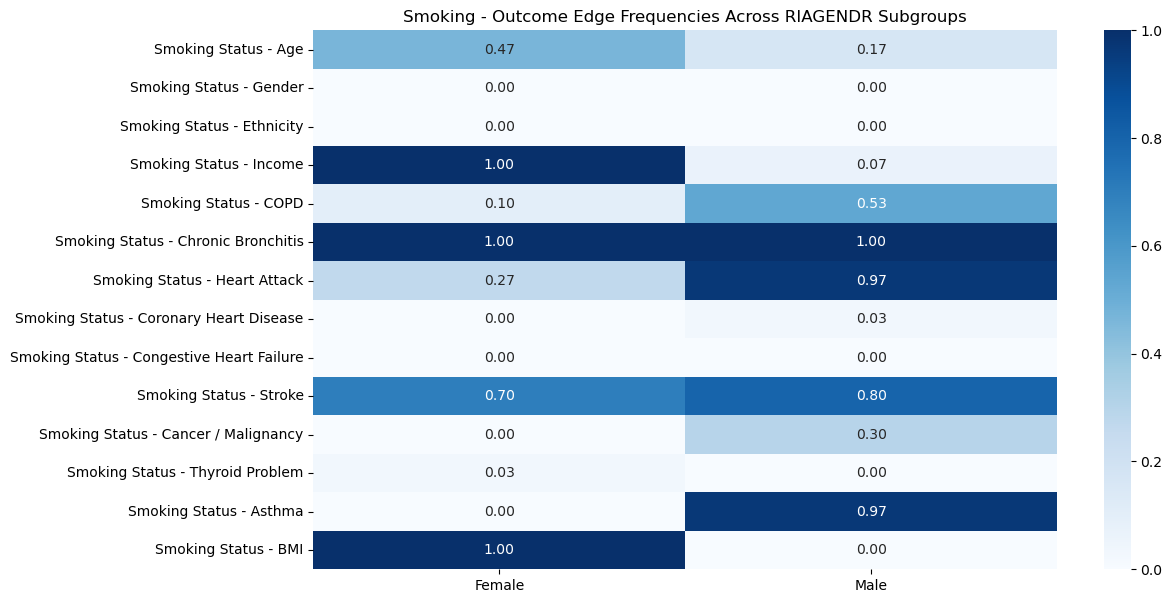

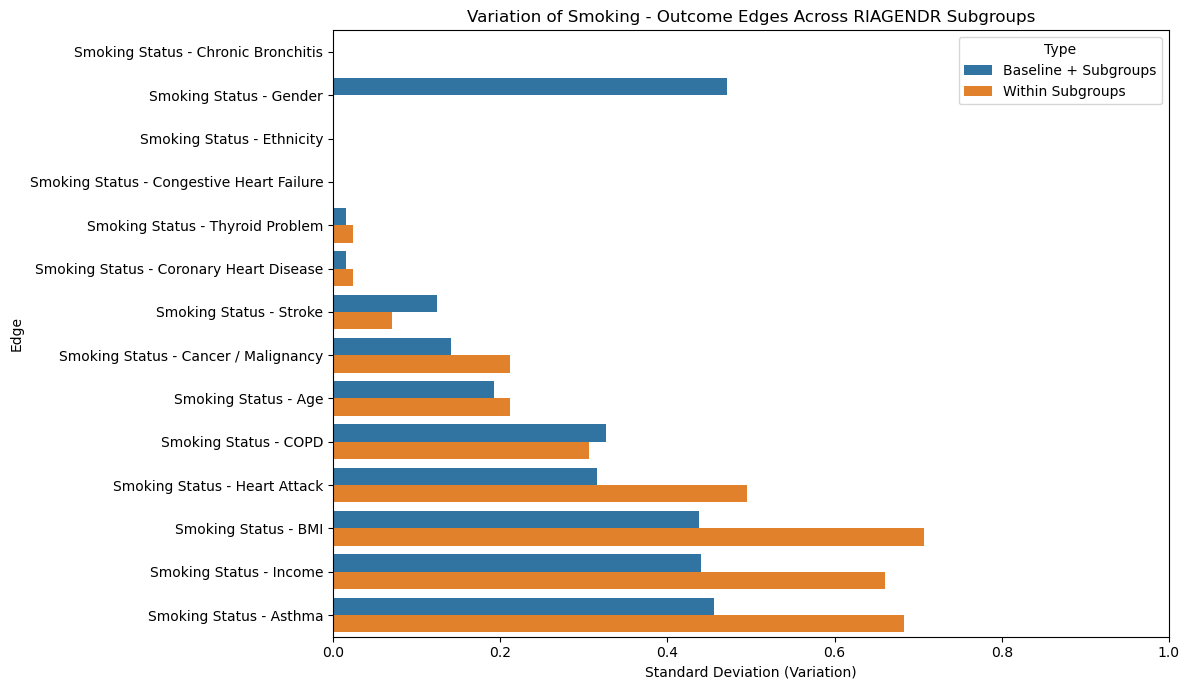


=== Edge Direction Stability for Gender Subgroups ===
                                           Directional Instability (Range)
Smoking Status — Stroke                                           0.966667
Smoking Status — Age                                              0.500000
Smoking Status — Chronic Bronchitis                               0.466667
Smoking Status — Income                                           0.433333
Smoking Status — Asthma                                           0.366667
Smoking Status — Heart Attack                                     0.366667
Smoking Status — Cancer / Malignancy                              0.233333
Smoking Status — COPD                                             0.100000
Smoking Status — BMI                                              0.066667
Smoking Status — Coronary Heart Disease                           0.033333
Smoking Status — Thyroid Problem                                  0.033333
Smoking Status — Congestive Heart Failure    

In [16]:
gender_label_map = {
    1: "Female",
    2: "Male",
}

gender_freq_matrix, gender_subgroups = run_ges_subgroup_analysis_smoking_only(
    df=df,
    demographic_col="RIAGENDR",
    label_map=gender_label_map,
    n_bootstraps=30
)

gender_direction_matrix, gender_instability_df = create_full_direction_matrix(
    subgroup_results=gender_subgroups,
    demographic_col="Gender",
    label_map=gender_label_map,
    friendly_labels=friendly_labels
)

gender_freq_matrix.to_excel("gender_freq_matrix.xlsx")
gender_direction_matrix.to_excel("gender_direction_matrix.xlsx")
gender_instability_df.to_excel("gender_instability_df.xlsx")
with pd.ExcelWriter("gender_subgroups_raw_data.xlsx") as writer:
    for subgroup_name, df_data in gender_subgroups.items():
        df_data.to_excel(writer, sheet_name=str(subgroup_name))

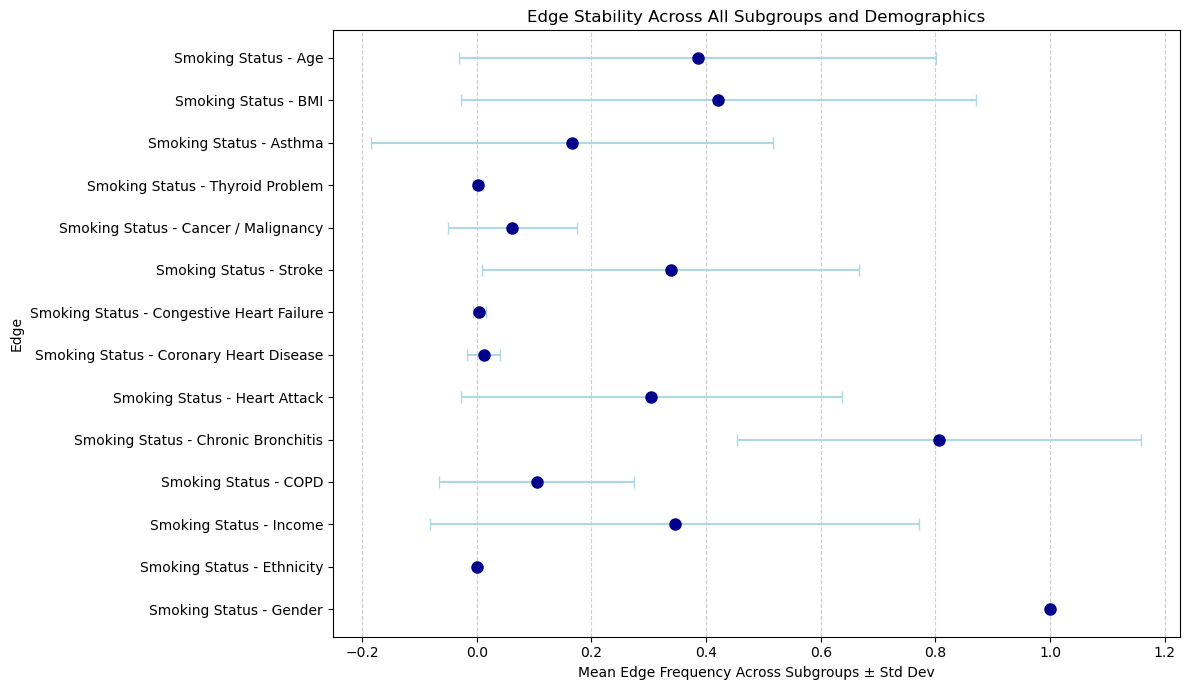

In [17]:
age_df = age_freq_matrix.add_prefix('Age_')
ethnicity_df = eth_freq_matrix.add_prefix('Ethnicity_')
gender_df = gender_freq_matrix.add_prefix('Gender_')

age_df = age_df.reset_index().rename(columns={'index': 'Edge'})
ethnicity_df = ethnicity_df.reset_index().rename(columns={'index': 'Edge'})
gender_df = gender_df.reset_index().rename(columns={'index': 'Edge'})
age_df_filtered = age_df[~age_df['Edge'].str.contains('Age')] 
ethnicity_df_filtered = ethnicity_df[~ethnicity_df['Edge'].str.contains('Ethnicity')]
gender_df_filtered = gender_df[~gender_df['Edge'].str.contains('Gender')]
age_df_filtered = age_df_filtered.set_index('Edge')
ethnicity_df_filtered = ethnicity_df_filtered.set_index('Edge')
gender_df_filtered = gender_df_filtered.set_index('Edge')
combined_freq_df = pd.concat([age_df_filtered, ethnicity_df_filtered, gender_df_filtered], axis=1)

combined_freq_df = combined_freq_df.reset_index()
combined_freq_df = combined_freq_df.rename(columns={'index': 'Edge'})

freq_cols = [col for col in combined_freq_df.columns if col != 'Edge']

combined_freq_df["Mean"] = combined_freq_df[freq_cols].mean(axis=1)
combined_freq_df["Std"] = combined_freq_df[freq_cols].std(axis=1)

plt.figure(figsize=(12, 7))

plt.errorbar(
    x=combined_freq_df["Mean"],      
    y=combined_freq_df["Edge"],      
    xerr=combined_freq_df["Std"], 
    fmt="o",
    color="darkblue",
    ecolor="lightblue",
    capsize=4, 
    markersize=8
)

plt.xlabel("Mean Edge Frequency Across Subgroups ± Std Dev")
plt.ylabel("Edge")
plt.title("Edge Stability Across All Subgroups and Demographics")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [18]:
from statsmodels.stats.proportion import proportion_confint

n_bootstraps = 30
stab_df_v1 = stab_df.copy()
stab_df_v1['n_bootstraps'] = n_bootstraps

stab_df_v1 = stab_df_v1[
    (stab_df_v1['var_i'] == "smoking_status") | (stab_df_v1['var_j'] == "smoking_status")
].reset_index(drop=True)

ci_lower = []
ci_upper = []

for idx, row in stab_df_v1.iterrows():
    count = int(row['edge_freq'] * row['n_bootstraps'])
    n = row['n_bootstraps']
    lower, upper = proportion_confint(count, n, alpha=0.05, method='wilson')
    ci_lower.append(lower)
    ci_upper.append(upper)

stab_df_v1['CI_lower'] = ci_lower
stab_df_v1['CI_upper'] = ci_upper

stab_df_v1['Edge'] = stab_df_v1.apply(
    lambda row: f"{friendly_labels.get(row['var_i'], row['var_i'])} - {friendly_labels.get(row['var_j'], row['var_j'])}",
    axis=1
)
v1_table = stab_df_v1[['Edge', 'edge_freq', 'CI_lower', 'CI_upper']].sort_values('edge_freq', ascending=False)
v1_table.to_excel("CI_smoking_edges.xlsx")
v1_table

Edge  edge_freq  CI_lower  CI_upper
0                     Smoking Status - Income   1.000000  0.886487  1.000000
1         Smoking Status - Chronic Bronchitis   1.000000  0.886487  1.000000
2                     Smoking Status - Stroke   1.000000  0.886487  1.000000
3                     Smoking Status - Gender   1.000000  0.886487  1.000000
4                     Smoking Status - Asthma   0.966667  0.833296  0.994091
5                       Smoking Status - COPD   0.900000  0.743789  0.965400
6               Smoking Status - Heart Attack   0.900000  0.743789  0.965400
7                        Smoking Status - BMI   0.833333  0.664356  0.926635
8                        Smoking Status - Age   0.000000  0.000000  0.113513
9                  Smoking Status - Ethnicity   0.000000  0.000000  0.113513
10    Smoking Status - Coronary Heart Disease   0.000000  0.000000  0.113513
11  Smoking Status - Congestive Heart Failure   0.000000  0.000000  0.113513
12       Smoking Status - Cancer / Malignancy   0.000000  0.000000  0.113513
13           Smoking Status - Thyroid Problem   0.000000  0.000000  0.113513

In [19]:
from scipy.stats import kruskal

n_bootstraps = 30

def compute_kruskal_for_demographic(subgroup_results, demographic_name, edge_connector='-'):
    all_edges = set()
    for group, result in subgroup_results.items():
        df_edges = result
        for _, row in df_edges.iterrows():
            edge = f"{row['var_i']}{edge_connector}{row['var_j']}"
            all_edges.add(edge)

    kruskal_rows = []

    for edge in all_edges:
        subgroup_arrays = []
        for group, result in subgroup_results.items():
            df_edges = result
            var_i, var_j = edge.split(edge_connector)
            match = df_edges[((df_edges['var_i'] == var_i) & (df_edges['var_j'] == var_j)) | ((df_edges['var_i'] == var_j) & (df_edges['var_j'] == var_i))]
            
            if len(match) > 0:
                count = int(match['edge_freq'].values[0] * n_bootstraps)
                arr = np.concatenate([np.ones(count), np.zeros(n_bootstraps - count)])
            else:
                arr = np.zeros(n_bootstraps)
            subgroup_arrays.append(arr)

        if all(np.array_equal(subgroup_arrays[0], arr) for arr in subgroup_arrays[1:]):
            H_stat, p_value = np.nan, np.nan
        else:
            H_stat, p_value = kruskal(*subgroup_arrays)

        kruskal_rows.append({ 'Edge': edge, 'Demographic': demographic_name, 'H_stat': H_stat, 'p_value': p_value })

    return pd.DataFrame(kruskal_rows)

kruskal_age = compute_kruskal_for_demographic(age_subgroups, 'Age')
kruskal_eth = compute_kruskal_for_demographic(ethnicity_subgroups, 'Ethnicity')
kruskal_gender = compute_kruskal_for_demographic(gender_subgroups, 'Gender')

kruskal_results = pd.concat([kruskal_age, kruskal_eth, kruskal_gender], ignore_index=True)

kruskal_results = kruskal_results.sort_values('p_value')
final_kruskal_results = kruskal_results.groupby(["Edge", "Demographic"]).mean("p_value")
final_kruskal_results.to_excel("final_kruskal_results.xlsx")
final_kruskal_results

H_stat       p_value
Edge                    Demographic                          
smoking_status-BMXBMI   Age          142.300728  3.275820e-28
                        Ethnicity    111.354792  3.741312e-23
                        Gender        59.000000  1.576720e-14
smoking_status-INDHHIN2 Age          147.937286  2.111704e-29
                        Ethnicity    107.301677  2.737371e-22
                        Gender        51.625000  6.718066e-13
smoking_status-MCQ010   Age          175.367816  3.266461e-35
                        Ethnicity      4.110345  3.912782e-01
                        Gender        55.193548  1.092267e-13
smoking_status-MCQ160B  Age            5.024038  5.407337e-01
                        Ethnicity           NaN           NaN
                        Gender              NaN           NaN
smoking_status-MCQ160C  Age           13.696602  3.321514e-02
                        Ethnicity           NaN           NaN
                        Gender         1.000000  3.173105e-01
smoking_status-MCQ160E  Age           58.123277  1.081848e-10
                        Ethnicity     86.088889  8.911000e-18
                        Gender        30.574618  3.212693e-08
smoking_status-MCQ160F  Age           96.840498  1.143696e-18
                        Ethnicity     54.824718  3.535664e-11
                        Gender         0.786667  3.751100e-01
smoking_status-MCQ160K  Age          135.612053  8.443677e-27
                        Ethnicity    116.132353  3.576999e-24
                        Gender              NaN           NaN
smoking_status-MCQ160M  Age                 NaN           NaN
                        Ethnicity           NaN           NaN
                        Gender         1.000000  3.173105e-01
smoking_status-MCQ160O  Age           48.656085  8.736051e-09
                        Ethnicity     16.328767  2.608294e-03
                        Gender        12.799743  3.466669e-04
smoking_status-MCQ220   Age           41.586735  2.218643e-07
                        Ethnicity     12.163265  1.617759e-02
                        Gender        10.411765  1.252150e-03
smoking_status-RIAGENDR Age                 NaN           NaN
                        Ethnicity           NaN           NaN
                        Gender              NaN           NaN
smoking_status-RIDAGEYR Age          139.268542  1.429909e-27
                        Ethnicity    120.325147  4.552104e-25
                        Gender         6.134788  1.325474e-02
smoking_status-RIDRETH1 Age                 NaN           NaN
                        Ethnicity           NaN           NaN
                        Gender              NaN           NaN